In [1]:
from preprocess import get_prepared_data
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


/Users/igorjakus/projects/neurohackathon/venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
# Load preprocessed, prepared data with original labels
# We want to divide the data into original 5 classes
# And change the shape to (n_samples, 178, 1) because DTW requires 3-dimensional vectors
X, y = get_prepared_data(oversample=False, relabel=False, time_series_reshape=True, standard_scaler=True)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
# KNN classifier on time series but using DTW instead of euclidean distance
knn_dtw = KNeighborsTimeSeriesClassifier(
    n_neighbors=3,
    metric="dtw",
    metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius": 10},   # TODO: check co to robi
    n_jobs=-1  # Wykorzystanie wszystkich rdzeni CPU
)

In [4]:
# Extracting some basic statistic features from every sample for Random Forest classifier
def extract_features(X):
    features = []
    for series in X:
        series = series.flatten()
        features.append([
            np.mean(series),
            np.std(series),
            np.min(series),
            np.max(series),
            np.percentile(series, 25),
            np.percentile(series, 75),
            np.median(series),
            np.sum(np.diff(series) ** 2),
            len(np.where(np.diff(series) > 0)[0]) / len(series),
        ])
    return np.array(features)


# Random Forest pipeline
rf_pipeline = Pipeline([
    ('feature_extraction', FunctionTransformer(extract_features)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [5]:
# Training models
print("Training KNN-DTW...")
knn_dtw.fit(X_train, y_train)

print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

Training KNN-DTW...
Training Random Forest...


Pipeline(steps=[('feature_extraction',
                 FunctionTransformer(func=<function extract_features at 0x151971b20>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [6]:
# Print the results
# Some metrics are scam :(
def print_results(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print(classification_report(y_true, y_pred))
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [7]:
# Predictions
y_pred_knn = knn_dtw.predict(X_test)


KNN-DTW Results:
              precision    recall  f1-score   support

           1       0.98      0.90      0.94       456
           2       0.55      0.68      0.61       455
           3       0.61      0.54      0.57       455
           4       0.75      0.64      0.69       456
           5       0.60      0.66      0.63       455

    accuracy                           0.69      2277
   macro avg       0.70      0.69      0.69      2277
weighted avg       0.70      0.69      0.69      2277



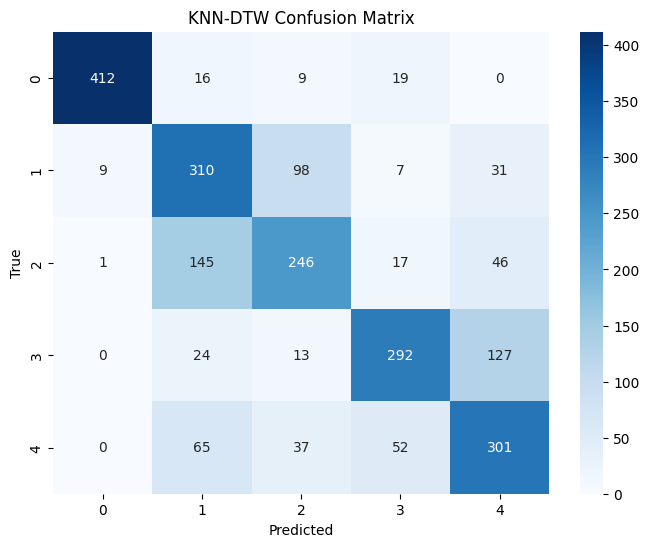

In [8]:
print_results(y_test, y_pred_knn, "KNN-DTW")

In [9]:
# Predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Ensemble - majority vote 
# this way we should get the best results sns
y_pred_ensemble = np.array([
    max(set([pred1, pred2]), key=[pred1, pred2].count)
    for pred1, pred2 in zip(y_pred_knn, y_pred_rf)
])


Random Forest Results:
              precision    recall  f1-score   support

           1       0.94      0.97      0.95       456
           2       0.60      0.56      0.58       455
           3       0.64      0.60      0.62       455
           4       0.79      0.70      0.74       456
           5       0.68      0.83      0.75       455

    accuracy                           0.73      2277
   macro avg       0.73      0.73      0.73      2277
weighted avg       0.73      0.73      0.73      2277



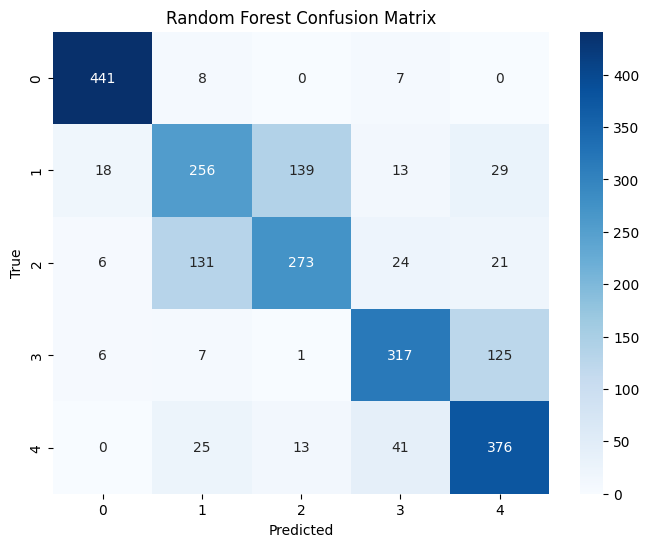


Ensemble Results:
              precision    recall  f1-score   support

           1       0.93      0.98      0.95       456
           2       0.52      0.81      0.63       455
           3       0.67      0.44      0.53       455
           4       0.77      0.75      0.76       456
           5       0.76      0.57      0.65       455

    accuracy                           0.71      2277
   macro avg       0.73      0.71      0.71      2277
weighted avg       0.73      0.71      0.71      2277



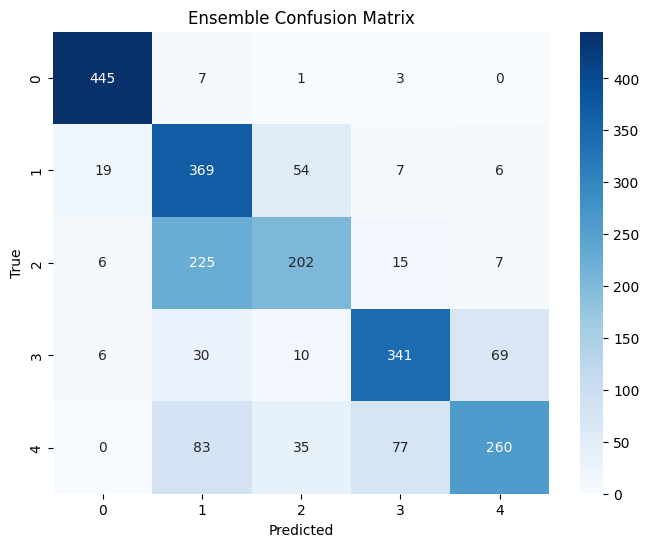

In [10]:
print_results(y_test, y_pred_rf, "Random Forest")
print_results(y_test, y_pred_ensemble, "Ensemble")